# Image inpainting over CIFAR-10

The purpose of this project is to build and train a neural network for image inpainting over the CIFAR-10 dataset. 

Inpainting is a restauration process where damaged, deteriorated, or missing parts of an artwork are filled in to present a complete image.

In our case, we create the portion of the image to be filled in by cropping a fixed size rectangular area from CIFAR-10 images.

The networks must be trained over the training set, and tested on the test set.
You can split the train set into a validation set, if you wish.

The metrics that will be used to evaluate you result is Mean Square Error.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers, models, metrics, utils
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

Here we load the dataset.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

image range is 0, 255
new image range is 0.0, 1.0


Let's see some examples.

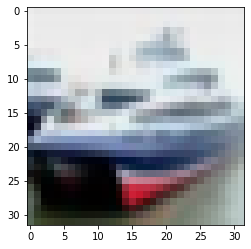

In [4]:
plt.imshow(x_test[1])
plt.show()

Now we hide a portion of the input, and the purpose of the network is to reconstruct it.

In [5]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

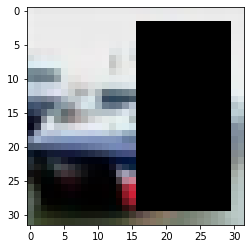

In [6]:
plt.imshow(masked_x_test[1])
plt.show()

# Approaches and evaluation

The network is supposed to take in input the masked image and fill in the missing part. 

You may basically follow two main approaches:
*   either you return the full image
*   you just return the missing crop

In the first case, the mse is to be evaluated on the full image; in the second case just on the crop (since on the reamining part is 0). 

If you want to take a different approach, you can ask for my approuval.



# What to deliver

As usual, you are supposed to deliver a single notebook comprising the code, the training history, and the evaluation on test data in terms of Mean Square Error.

Good work!

# Student infos
* Name: **Igor**
* Surname: **Iurevici**
* Registration number: **0937982**

#Architecture
A **U-Net** architecture is used to train a generalized inpainting model.

In [7]:
# Downsample
def downsample_block(x, n):
  c = layers.Conv2D(n, (3,3), activation='relu', padding='same')(x)
  c = layers.Conv2D(n, (3,3), activation='relu', padding='same')(c)
  p = layers.MaxPool2D((2,2), padding='same')(c)
  return c, p

# Upsample
def upsample_block(x, y, n):
  u = layers.Conv2DTranspose(n, (2,2), (2,2), padding='same')(x)
  u = layers.concatenate([u, y])
  u = layers.Conv2D(n, (3,3), activation='relu', padding='same')(u)
  u = layers.Conv2D(n, (3,3), activation='relu', padding='same')(u)
  return u

In [8]:
# Input
i = layers.Input(shape=(32, 32, 3))

# Encoder layers
c1, p1 = downsample_block(i, 16)
c2, p2 = downsample_block(p1, 32)
c3, p3 = downsample_block(p2, 64)
c4, p4 = downsample_block(p3, 128)

# Bottleneck layers
b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p4)
b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(b)

# Decoder layers
u6 = upsample_block(b, c4, 128)
u7 = upsample_block(u6, c3, 64)
u8 = upsample_block(u7, c2, 32)
u9 = upsample_block(u8, c1, 16)

# Output
o = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(u9)

# Model
model = models.Model([i], [o])
model.compile(optimizer='adam', loss='mse')

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 16)   0           ['conv2d_1[0][0]']               
                                                                                              

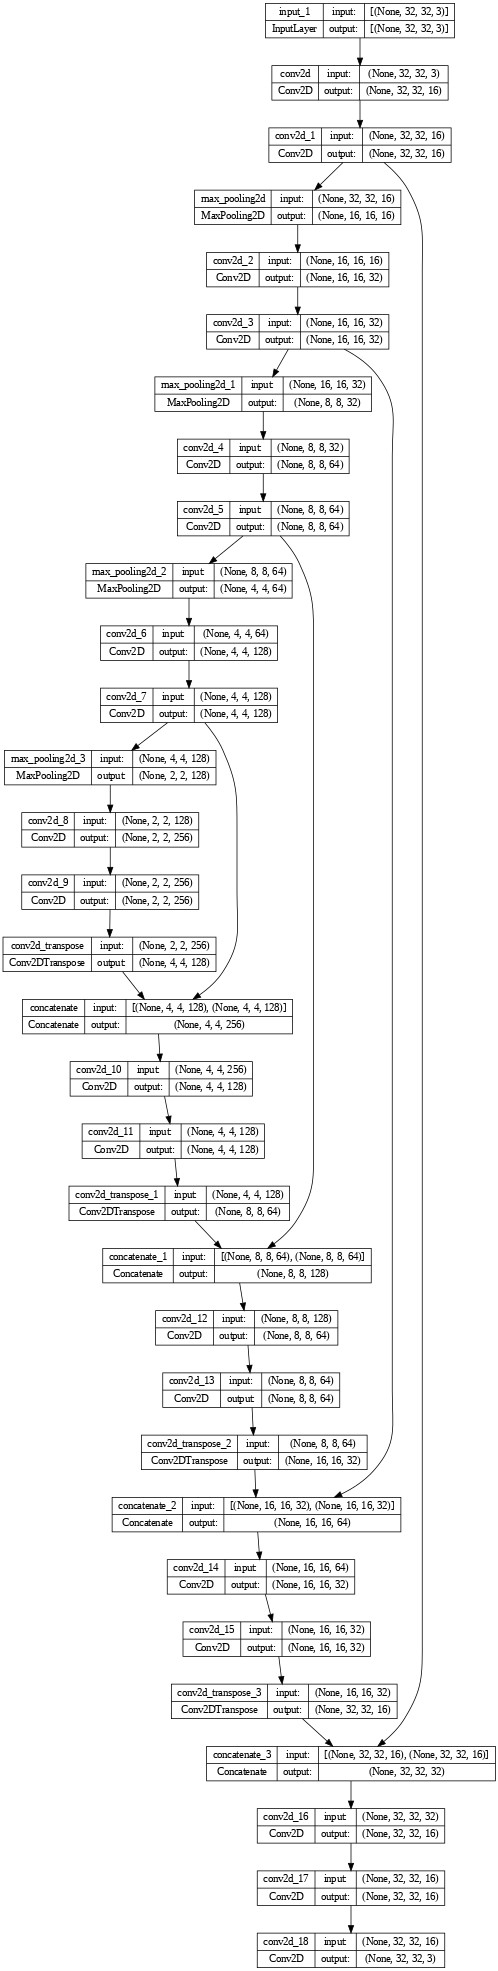

In [10]:
# Plot model architecture
utils.plot_model(model, show_shapes=True, dpi=54)

#Training
The model gets masked image in input and the original image as ground truth.

In [11]:
# Train split -> (train, validation)
x_train1, x_val1 = train_test_split(x_train, test_size=0.2, random_state=42)
masked_x_train1 = mask(np.copy(x_train1), (2,16,30,30))
masked_x_val1 = mask(np.copy(x_val1), (2,16,30,30))

# Shape check
print("Train set shape: ", x_train1.shape)
print("Validation set shape: ", x_val1.shape)
print("Masked train set shape: ", masked_x_train1.shape)
print("Masked validation set shape: ", masked_x_val1.shape)

Train set shape:  (40000, 32, 32, 3)
Validation set shape:  (10000, 32, 32, 3)
Masked train set shape:  (40000, 32, 32, 3)
Masked validation set shape:  (10000, 32, 32, 3)


In [12]:
# CONSTS
BATCH = 64
EPOCHS = 10
TRAIN_SIZE = len(x_train1)
VAL_SIZE = len(x_val1)
TRAIN_STEPS = TRAIN_SIZE/BATCH
VAL_STEPS = VAL_SIZE/BATCH

# Training
history = model.fit(
    masked_x_train1, x_train1,
    batch_size = BATCH,
    epochs = EPOCHS,
    validation_data = (masked_x_val1, x_val1),
    steps_per_epoch = TRAIN_STEPS,
    validation_steps = VAL_STEPS
)

Epoch 1/10
625/625 [==============================] - 14s 17ms/step - loss: 0.0153 - val_loss: 0.0106
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
625/625 [==============================] - 10s 15ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 8/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 9/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 10/10
625/625 [==============================] - 11s 17ms/step - loss: 0.008

More than 10 epochs showed a decrease of loss on training set but staling/increase on validation set loss, which is symptom of overfitting.

Tried also batch size of 32 but the result doesn't differ particularly and the training process is a little bit slower.

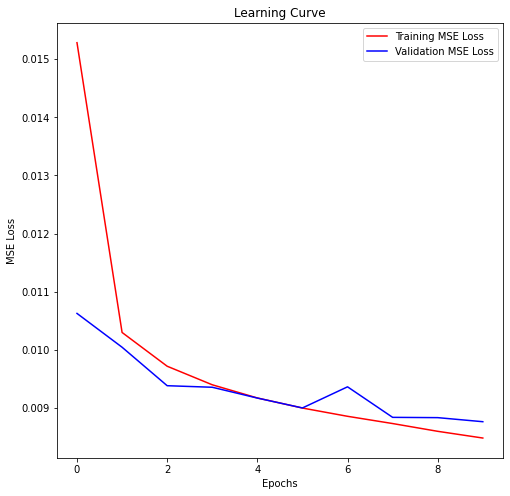

In [13]:
## Learning curve
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot
plt.figure(figsize = (8,8))
plt.plot(training_loss, 'r', label='Training MSE Loss')
plt.plot(validation_loss, 'b', label='Validation MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

#Evaluation

In [14]:
## MSE (full image)
x_pred = model.predict(masked_x_test)

mse = np.mean(np.square(x_pred - x_test), axis=1)
print("Set shape: ", mse.shape)
print("MSE mean: ", np.mean(mse))
print("MSE standard deviation: ", np.std(mse))

313/313 [==============================] - 2s 4ms/step
Set shape:  (10000, 32, 3)
MSE mean:  0.008807537
MSE standard deviation:  0.016165638


MSE mean ranges in 0.0085-0.0090

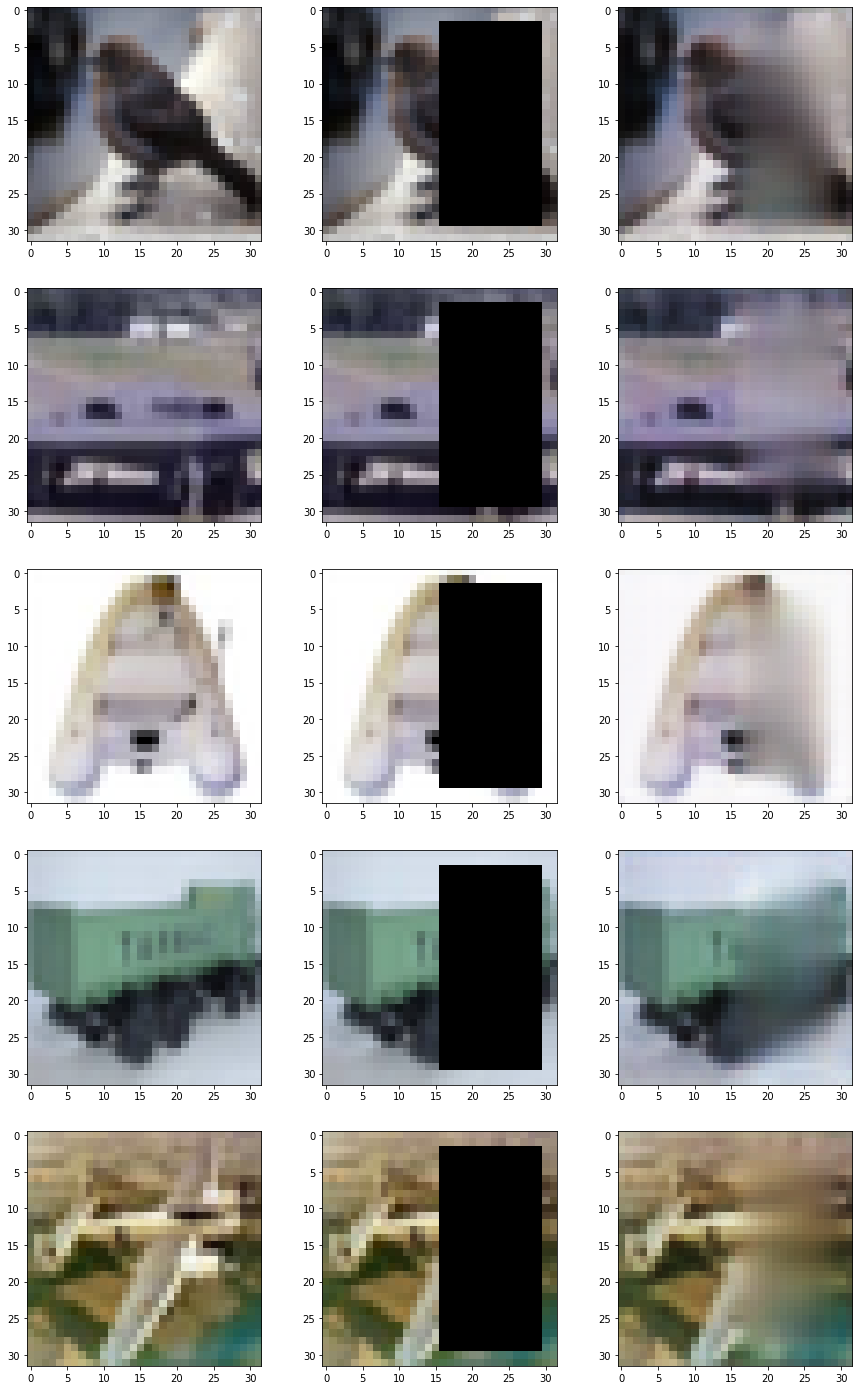

In [16]:
## Figure of ground truth, masked and predicted image
batch_size = 5
offset = np.random.randint(0, (len(x_test)-batch_size))
#offset = 0

fig, axs = plt.subplots(nrows=batch_size, ncols=3, figsize=(15, 5*batch_size))

for i in range(batch_size):
  j = i + offset
  axs[i][0].imshow(x_test[j])
  axs[i][1].imshow(masked_x_test[j])
  axs[i][2].imshow(x_pred[j])

plt.show()

Considering the large size of the mask, the results are pretty satisfying even if it doesn't capture well the human perception of the images.

In fact, by directly looking at the predicted images (previous cell) it is noticible how some images are not really well reconstructed (to the human eye), but others are very similar to the original.